<a href="https://colab.research.google.com/github/VincentZuo/NasdaqJuggernaut/blob/master/cs231_Buffet_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpha_vantage
!pip install pytz

     |████████████████████████████████| 1.2MB 7.3MB/s 
     |████████████████████████████████| 153kB 40.0MB/s 
     |████████████████████████████████| 256kB 42.1MB/s 
  Created wheel for alpha-vantage: filename=alpha_vantage-2.2.0-cp36-none-any.whl size=25705 sha256=72c2dbcf556585b301813fd30a9964e5ec86cb68065aebb550498dec8c4269ec
  Stored in directory: /root/.cache/pip/wheels/3a/fa/05/80b0afcbd2a4de8bd2a0c5cd77084e3d3a9cc12c48be9b7f84
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=763419519d9eea0df53bea41d347b2a6dd817c722b9755448f57a3082bbc275d
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built alpha-vantage idna-ssl


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
ALPHAVANTAGE_API_KEYS = ["XX6G2N4G6ZLM3QAT", "AXE6TX2TV7749TFN", "5J256FHJ75YQUM4V"]


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Set up api access

In [0]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

ts = TimeSeries(key=ALPHAVANTAGE_API_KEYS[1],  output_format='pandas')

Data processing 

In [0]:
import numpy as np
import time
import pickle
from datetime import datetime

# Get daily closing data
def get_close_data(symbol):
  daily_data = ts.get_daily(symbol=symbol, outputsize='full')
  close_data = daily_data[0].sort_index(axis=0, ascending=True)[['4. close']].to_numpy().flatten() 
  return close_data

# Volatility adjusted target percentage change.
def vol_adj_delta(benchmark_std, ticker_std, target_delta):
  return ticker_std / benchmark_std * target_delta

# Windowed series to prediction generation
def window_predction(index, window_size, array, adj_delta_target):
  # Skip out of bounds
  if (index < window_size or index + 2 >= len(array)):
    return None
  current_delta = float(array[index])/float(array[index-1]) - 1.0
  # We are only interested in delta above adj_delta_target
  if abs(current_delta) < adj_delta_target:
    return None
  # Gap down is 0 label, gap up is 1 label
  label = 0
  if current_delta > 0:
    label = 1
  return (array[index-window_size:index], label)

# Run window_predction across the entire array
def get_array_training_labels(array, window_size, adj_delta_target):
  training_data = []
  training_lbls = []
  for i in range(len(array)):
    result = window_predction(i, window_size, array, adj_delta_target)
    if result == None:
      continue
    training_data.append(result[0])
    training_lbls.append(result[1])
  return (training_data, training_lbls)

# generate a 2d array from series, will used as image input of size window_size x window_size
def gen_image_from_series(window_data, pos_neg=False):
  window_size = len(window_data)
  high = np.max(window_data)
  low = np.min(window_data)
  result = np.zeros((window_size+1, window_size, 1))
  if pos_neg:
    result = np.full((window_size+1, window_size, 1), -0.5)
  for i in range(window_size):
    # Normalize data to within window
    position = int(window_size * (window_data[i] - low)/(high - low))
    result[position][i][0] += 1
  return result

def gen_ticker_map(ticker_array):
  dict_data = {}
  for ticker in ticker_array:
    series_data = get_close_data(ticker)
    dict_data[ticker] = series_data
    print(ticker + " produced number of traning samples: " + str(series_data.size))
    time.sleep(15)
  file_name = str(datetime.date(datetime.now())) + "tickers"
  with open(file_name, 'wb') as handle:
    pickle.dump(dict_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
  

# Generate all traning images for all tickers in array
def gen_ticker_train_data(window_size, target_delta, benmark_std, pos_neg=False):
  file_name = str(datetime.date(datetime.now())) + "tickers"
  ticker_map = {}
  with open(file_name, 'rb') as handle:
      ticker_map = pickle.load(handle)
  training_imgs = []
  training_lbls = []
  for ticker, series_data in ticker_map.items():
    series_std = np.std(series_data)
    adj_del = vol_adj_delta(benmark_std, series_std, target_delta)
    data, labels = get_array_training_labels(series_data,\
                                             window_size,\
                                             adj_del)
    for i in range(len(data)):
      image_data = gen_image_from_series(data[i], pos_neg)
      training_imgs.append(image_data)
      training_lbls.append(labels[i])
    print(ticker + " produced number of traning samples: " + str(len(data)))
    print("Postive: ", sum(labels), " negative: ", len(data) - sum(labels))
  return (training_imgs, training_lbls)





In [0]:
BENCH_MARK_SERIES = get_close_data('SPY')
BENCH_MARK_VOLATILITY = np.std(BENCH_MARK_SERIES)

In [0]:
import random

# Data split
def load_stock_data(X_in, y_in, train_ratio, val_ratio, normalize=True):

  zipped_list = list(zip(X_in, y_in))
  random.shuffle(zipped_list)
  X_in, y_in = zip(*zipped_list)

  X_in = np.array(X_in)
  y_in = np.array(y_in)

  num_training = int(train_ratio*len(X_in))
  num_validation = int(val_ratio*len(X_in))
  num_testing = len(X_in) - num_training - num_validation

  # Subsample the data
  mask = range(num_training + num_validation, num_training + num_validation + num_testing)
  X_test = X_in[mask]
  y_test = y_in[mask]
  mask = range(num_training, num_training + num_validation)
  X_val = X_in[mask]
  y_val = y_in[mask]
  mask = range(num_training)
  X_train = X_in[mask]
  y_train = y_in[mask]

  if normalize:
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel
  return X_train, y_train, X_val, y_val, X_test, y_test


Pick Stock

In [8]:
etf_tickers = ['SPY', 'XLK', 'XLE', 'XLF', 'XLU', 'XLV', 'XLI', 'XLY', 'XLP', 'XLB', 'REM']
tech_tickers = ['AAPL', 'MSFT', 'GOOG', 'FB', 'TSLA', 'AMZN']
consumer_tickers = ['UBER', 'DAL', 'CCL']
energy_tickers = ['XOM', 'CVX', 'OXY']

experiment_tickers = etf_tickers + tech_tickers + energy_tickers + consumer_tickers + energy_tickers

gen_ticker_map(experiment_tickers)

# data, labels = gen_ticker_train_data(30, 0.02, BENCH_MARK_VOLATILITY, pos_neg=False)
# X_train, y_train, X_val, y_val, X_test, y_test = load_stock_data(data, labels, 0.7, 0.15, normalize=True)

data, labels = gen_ticker_train_data(30, 0.02, BENCH_MARK_VOLATILITY, pos_neg=True)
X_train, y_train, X_val, y_val, X_test, y_test = load_stock_data(data, labels, 0.7, 0.15, normalize=False)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

SPY produced number of traning samples: 5033
XLK produced number of traning samples: 5033
XLE produced number of traning samples: 5033
XLF produced number of traning samples: 5033
XLU produced number of traning samples: 5033
XLV produced number of traning samples: 5033
XLI produced number of traning samples: 5033
XLY produced number of traning samples: 5033
XLP produced number of traning samples: 5033
XLB produced number of traning samples: 5033
REM produced number of traning samples: 3296
AAPL produced number of traning samples: 5033
MSFT produced number of traning samples: 5033
GOOG produced number of traning samples: 1560
FB produced number of traning samples: 2025
TSLA produced number of traning samples: 2502
AMZN produced number of traning samples: 5033
XOM produced number of traning samples: 5033
CVX produced number of traning samples: 5033
OXY produced number of traning samples: 5033
UBER produced number of traning samples: 271
DAL produced number of traning samples: 3297
CCL pr

In [0]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
 
 
# Build CNN model
def model_init_fn():
   model = None
   num_classes = 2
   channel_1 = 16
   channel_2 = 16
   initializer = tf.initializers.VarianceScaling(scale=2.0)
   many_layers = [
       tf.keras.layers.InputLayer(input_shape=(31, 30, 1)),
       tf.keras.layers.Conv2D(filters=channel_1, \
                              kernel_size=5, \
                              strides=(1, 1), \
                              padding="SAME", \
                              activation='relu', \
                              use_bias=True, \
                              kernel_initializer=initializer, \
                              bias_initializer=initializer, \
                              kernel_regularizer=regularizers.l1_l2(l1=5e-4, l2=5e-3), \
                              bias_regularizer=regularizers.l2(1e-4), \
                              activity_regularizer=regularizers.l2(1e-5), \
                              name='conv1'),
       tf.keras.layers.Conv2D(filters=channel_2, \
                              kernel_size=3, \
                              strides=(1, 1), \
                              padding="SAME", \
                              activation='relu', \
                              use_bias=True, \
                              kernel_initializer=initializer, \
                              bias_initializer=initializer, \
                              kernel_regularizer=regularizers.l1_l2(l1=5e-4, l2=5e-3), \
                              bias_regularizer=regularizers.l2(1e-4), \
                              activity_regularizer=regularizers.l2(1e-5), \
                              name='conv2'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(num_classes, \
                             activation='softmax', \
                             kernel_initializer=initializer)]
   model = tf.keras.Sequential(many_layers)
   return model
 
learning_rate = 1e-2
def optimizer_init_fn():
   optimizer = None
   optimizer = tf.keras.optimizers.SGD(
       learning_rate=learning_rate, momentum=0.5, nesterov=True, name='SGD'
   )
   return optimizer


In [10]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=50, epochs=10, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

Epoch 1/10
653/653 [==============================] - 49s 75ms/step - loss: 1.1915 - sparse_categorical_accuracy: 0.5143 - val_loss: 1.1298 - val_sparse_categorical_accuracy: 0.5272
Epoch 2/10
653/653 [==============================] - 49s 75ms/step - loss: 1.0972 - sparse_categorical_accuracy: 0.5343 - val_loss: 1.0705 - val_sparse_categorical_accuracy: 0.5307
Epoch 3/10
653/653 [==============================] - 50s 76ms/step - loss: 1.0405 - sparse_categorical_accuracy: 0.5453 - val_loss: 1.0204 - val_sparse_categorical_accuracy: 0.5292
Epoch 4/10
653/653 [==============================] - 48s 74ms/step - loss: 0.9925 - sparse_categorical_accuracy: 0.5497 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.5236
Epoch 5/10
653/653 [==============================] - 48s 73ms/step - loss: 0.9515 - sparse_categorical_accuracy: 0.5577 - val_loss: 0.9419 - val_sparse_categorical_accuracy: 0.5166
Epoch 6/10
653/653 [==============================] - 47s 73ms/step - loss: 0.9158 - spars

[0.8160369992256165, 0.5117907524108887]

Visualize the shape of the layers

In [11]:

for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv1 (5, 5, 1, 16)
conv2 (3, 3, 16, 16)


Visualize the layer weights

In [0]:
from matplotlib import pyplot

def vis_weight(layer_num):
  filters, biases = model.layers[layer_num].get_weights()
  f_min, f_max = filters.min(), filters.max()
  filters = (filters - f_min) / (f_max - f_min)

  n_filters, ix = filters.shape[-1], 1
  for i in range(4):
    for _ in range(4):
      # specify subplot and turn of axis
      ax = pyplot.subplot(4, 4, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      pyplot.imshow(filters[:, :, 0, ix-1], cmap='gray')
      ix += 1
  # show the figure
  pyplot.show()

  # show the figure
  pyplot.show()

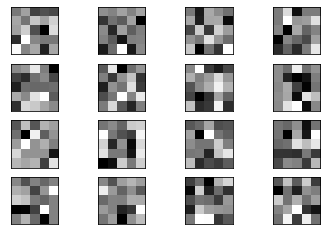

In [56]:
vis_weight(0)

In [0]:
new_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[1].output)

In [14]:
print (X_test[0, :, :, :].shape)
result_data = new_model.predict(X_test[0, :, :, :])

(31, 30, 1)


In [29]:
print(result_data.shape)
print(y_test[1])

(31, 30, 1, 16)
1


In [0]:
def visual_fmaps(feature_maps):
  ix = 1
  for i in range(4):
    for _ in range(4):
      # specify subplot and turn of axis
      ax = pyplot.subplot(4, 4, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      pyplot.imshow(feature_maps[:, :, 0, ix-1], cmap='gray')
      ix += 1
  # show the figure
  pyplot.show()

def visual_original(original_data):

  ax = pyplot.subplot(4, 4, 1)
  ax.set_xticks([])
  ax.set_yticks([])
  # plot filter channel in grayscale
  pyplot.imshow(original_data[:, :, 0], cmap='gray')

  pyplot.show()

1


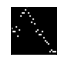

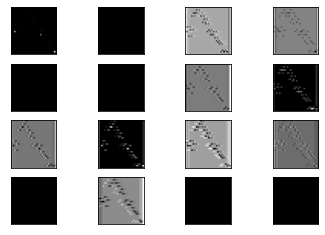

In [36]:
print(y_test[1])
visual_original(X_test[1, :, :, :])
visual_fmaps(new_model.predict(X_test[1, :, :, :]))

0


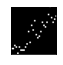

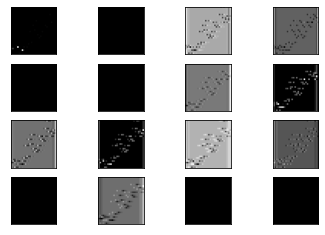

In [37]:
print(y_test[2])
visual_original(X_test[2, :, :, :])
visual_fmaps(new_model.predict(X_test[2, :, :, :]))

1


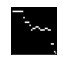

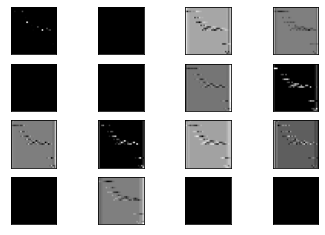

In [38]:
print(y_test[3])
visual_original(X_test[3, :, :, :])
visual_fmaps(new_model.predict(X_test[3, :, :, :]))

1


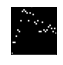

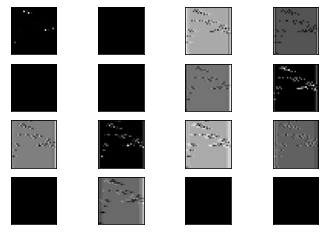

In [39]:
print(y_test[4])
visual_original(X_test[4, :, :, :])
visual_fmaps(new_model.predict(X_test[4, :, :, :]))

0


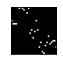

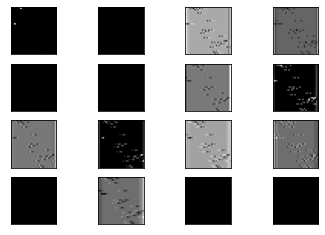

In [41]:
print(y_test[6])
visual_original(X_test[6, :, :, :])
visual_fmaps(new_model.predict(X_test[6, :, :, :]))

1


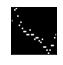

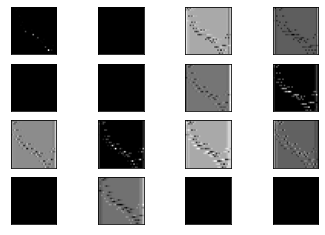

In [42]:
print(y_test[10])
visual_original(X_test[10, :, :, :])
visual_fmaps(new_model.predict(X_test[10, :, :, :]))